This dataset, called UTKFace, is available both on [Kaggle](https://www.kaggle.com/datasets/jangedoo/utkface-new?datasetId=44109) and on [Github](https://susanqq.github.io/UTKFace/). This dataset is a large-scale face dataset with faces ranging from 0 to 116 years old. This dataset contains over 20,000 face images. Each image includes only a single face, and includes annotations of age, gender, and ethnicity. Age is an integer from 0 to 116, gender is either 0 (male) or 1 (female), and race is an integer from 0 to 4, i.e., White (0), Black (1), Asian (2), Indian (3), Others (4).  These images also contain variation in pose, facial expression, illumination, occlusion, and resolution. This dataset is available for non-commerical research purposes only.

The objective of this project is to develop a convolutional neural network (CNN) that will work to predict the age and gender of the faces found in this dataset. The accuracy and loss of the CNN model will be analyzed. Lastly, the trained CNN model will work to predict the age and gender on several example images. 

This project was inspired by other great works on this dataset, such as the ones by [Uzair Siddiqui](https://www.kaggle.com/code/uzzivirus/age-and-gender-detection/notebook#From-Unstructured-data-to-Structured-data), [Rahul D Shetty](https://www.kaggle.com/code/rahuldshetty/age-and-gender-estimation-using-cnn), and [Venu Gopal Kadamba](https://www.kaggle.com/code/venugopalkadamba/face-regeneration-using-autoencoders). Their works on this dataset have also been included in the references section below.

<a id="set"></a>
# **Set Up**

In [1]:
# Loading necessary libraries and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

In [2]:
# Creating path for UTKFace dataset
path = Path("UTKFace")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))

In [3]:
# Viewing length of filenames
print(len(filenames))

23708


In [4]:
# Viewing examples of filenames
print(filenames[:5])

['100_0_0_20170112213500903.jpg.chip.jpg', '100_0_0_20170112215240346.jpg.chip.jpg', '100_1_0_20170110183726390.jpg.chip.jpg', '100_1_0_20170112213001988.jpg.chip.jpg', '100_1_0_20170112213303693.jpg.chip.jpg']


In the two code chunks above, we can see that there are 23708 filenames (images) in the UTKFace dataset. By viewing five examples of these filenames, we can get an idea of the structure of the naming convention. For example, the first filename shown above is '26_0_2_20170104023102422.jpg.chip.jpg'. The first three numbers reflect the age, gender, and race of the face in the image, respectively. So, this particular face would have an age of 26, gender as male (0), and race as Asian (2). 

<a id="pre"></a>
# **Data Preprocessing**

In [5]:
# Shuffling the data
np.random.seed(42)
np.random.shuffle(filenames)

In [6]:
# Separating age and gender
age_labels, gender_labels, image_path = [], [], []
for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])

In [7]:
# Creating new dataframe 'data' with just 'image', 'age', and 'gender' columns
data = pd.DataFrame()
data['image'], data['age'], data['gender'] = image_path, age_labels, gender_labels

The code chunks above have shuffled the images in 'filenames' and have created a new dataframe called 'data'. In this new dataframe, I have separated the age and gender attributes from the image filename. 'age', 'gender' and 'image' will now be the three columns of this dataframe. 

In [8]:
# Mapping gender=0 to "Male" and gender=1 to "Female"
gender_dict = {0:"Male",1:"Female"}

In [9]:
# Viewing dtypes prior to preprocessing
print(data.dtypes)

image     object
age       object
gender    object
dtype: object


In [10]:
# Assigning dtypes to 'age' and 'gender'
data = data.astype({'age':'float32', 'gender': 'int32'})

The code chunks above have mapped "Male" and "Female" to 0 and 1 for gender. Also, by printing the dtypes of the dataframe, we can see that 'image', 'age', and 'gender' are all object types. To remedy this, I have converted 'age' to float32 and 'gender' to int32. 

<a id="eda"></a>
# **Exploratory Data Analysis**

In [11]:
# Viewing new dataframe
data.head()

,image,age,gender
0,49_1_0_20170104185652921.jpg.chip.jpg,49.0,1
1,17_1_0_20170109214200825.jpg.chip.jpg,17.0,1
2,17_1_4_20170103201233799.jpg.chip.jpg,17.0,1
3,29_0_4_20170103235921692.jpg.chip.jpg,29.0,0
4,26_1_2_20170116180208093.jpg.chip.jpg,26.0,1


Above, we can see the first five entries in the new dataframe. There are now three columns: 'image', 'age', and 'gender'. The 'age' column now appears to be a float type and the 'gender' column now appears to be an int type. We can confirm this below with .info().

In [12]:
# Viewing data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   23708 non-null  object 
 1   age     23708 non-null  float32
 2   gender  23708 non-null  int32  
dtypes: float32(1), int32(1), object(1)
memory usage: 370.6+ KB


Above, we can confirm the overall structure of the dataframe. Again, there are 23708 images (entries) and three columns (attributes). The 'age' column is now a float32 type and the 'gender' column is now an int32 type. 

[Text(0.5, 1.0, 'Distribution of Age')]

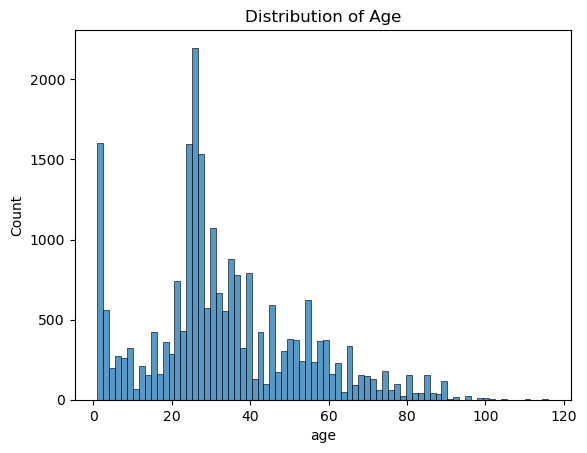

In [13]:
# Plotting the distribution of 'age'
sns.histplot(data.age).set(title="Distribution of Age")

Above, we can see the distribution of age. At a glance, the highest distribution of age appears to be between 20 and 40 years (~25 years). There also appears to be a higher distribution of faces with an age of ~0. Lastly, there is a much lower distribution of faces with older ages, i.e. >80 years. 

[Text(0.5, 1.0, 'Distribution of Gender')]

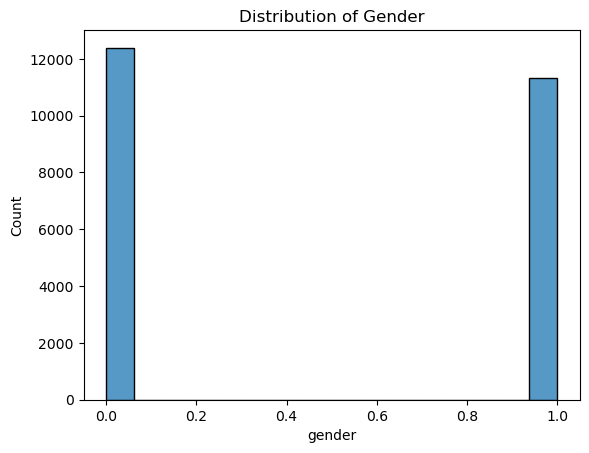

In [14]:
# Plotting the distribution of 'gender'
sns.histplot(data.gender).set(title="Distribution of Gender")

Above, we can see the distribution of gender. At a glance, it is clear that there are more faces with gender=0 (male) than there are faces with gender=1 (female). However, this difference does not appear to be significant. 

<a id="pre2"></a>
# **More Preprocessing**

In [15]:
# Applying train_test_split to dataframe
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [16]:
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
import numpy as np

# Extracting features from images
x_train = []
for file in train.image:
    img = load_img("UTKFace/" + file, color_mode="grayscale")
    img = img.resize((128, 128), Image.Resampling.LANCZOS)
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train)
x_train = x_train.reshape(len(x_train), 128, 128, 1)


In [17]:
# Viewing new shape of x_train
x_train.shape

(18966, 128, 128, 1)

In [18]:
# Normalizing the data
x_train = x_train/255
y_gender = np.array(train.gender)
y_age = np.array(train.age)

In [19]:
# Setting input_size 
input_size = (128,128,1)

In the code chunks above, the data is further preprocessed so that it is prepared for the model. Train test split has been applied so that the training size is 80% and the test size is 20%. The features have also been extracted from the images and the shape of x_train is now (18966, 128, 128, 1). Lastly, the data has been normalized. This will help reduce the computational footprint of this project.

<a id="model"></a>
# **Building the Model**

In [20]:
# Building the CNN model
inputs = Input((input_size))
X = Conv2D(64, (3, 3), activation='relu', kernel_initializer = glorot_uniform(seed=0))(inputs)
X = BatchNormalization(axis = 3)(X)
X = MaxPooling2D((3, 3))(X)

X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Flatten()(X)

dense_1 = Dense(256, activation='relu')(X)
dense_2 = Dense(256, activation='relu' )(X)
dense_3 = Dense(128, activation='relu' )(dense_2)
dropout_1 = Dropout(0.4)(dense_1)
dropout_2 = Dropout(0.4)(dense_3)
output_1 = Dense(1,activation='sigmoid', name='gender_output')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_output')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1,output_2])

In [21]:
model.compile(
    optimizer='adam',
    loss={
        'gender_output': 'binary_crossentropy',
        'age_output': 'mae'  # or 'mse'
    },
    metrics={
        'gender_output': ['accuracy'],
        'age_output': ['mae']
    }
)


In [22]:
# Viewing the structure of the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 126, 126, 64)      │             640 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 126, 126, 64)      │             256 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 42, 42, 64)        │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 40, 40, 128)       │          73,856 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 20, 20, 128)       │               0 │ conv2d_1[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 18, 18, 256)       │         295,168 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 9, 9, 256)         │               0 │ conv2d_2[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 20736)             │               0 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 256)               │       5,308,672 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 256)               │       5,308,672 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 128)               │          32,896 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 256)               │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 128)               │               0 │ dense_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gender_output (Dense)         │ (None, 1)                 │             257 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ age_output (Dense)            │ (None, 1)                 │             12

 Total params: 11,020,546 (42.04 MB)

 Trainable params: 11,020,418 (42.04 MB)

 Non-trainable params: 128 (512.00 B)

The summary of the model can be seen above. This model contains many layers, such as three convolutional layers, one batch normalization layer, three MaxPooling2D layers, one flatten layer, three dense layers, and two dropout layers. With this model, there are 11,020,546 total parameters, and 11,020,418 of them are trainable parameters. I have also employed the Adam optimizer with binary crossentropy and MAE loss. 

<a id="modelf"></a>
# **Fitting the Model**

In [23]:
# Fitting and training the model!
history = model.fit(x=x_train, y=[y_gender, y_age], batch_size = 10, epochs=20, validation_split= 0.1)

Epoch 1/20
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 673s 390ms/step - age_output_loss: 11.7751 - age_output_mae: 11.7752 - gender_output_accuracy: 0.7716 - gender_output_loss: 0.4835 - loss: 12.2588 - val_age_output_loss: 13.7010 - val_age_output_mae: 13.7030 - val_gender_output_accuracy: 0.8366 - val_gender_output_loss: 0.3699 - val_loss: 14.0725
Epoch 2/20
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 4651s 3s/step - age_output_loss: 9.0897 - age_output_mae: 9.0896 - gender_output_accuracy: 0.8356 - gender_output_loss: 0.3618 - loss: 9.4514 - val_age_output_loss: 8.1327 - val_age_output_mae: 8.1372 - val_gender_output_accuracy: 0.8450 - val_gender_output_loss: 0.3380 - val_loss: 8.4751
Epoch 3/20
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 44168s 26s/step - age_output_loss: 8.3072 - age_output_mae: 8.3072 - gender_output_accuracy: 0.8590 - gender_output_loss: 0.3193 - loss: 8.6265 - val_age_output_loss: 7.2533 - val_age_output_mae: 7.2590 - val_gender_output_accuracy: 0.8651 - val_gender_output_loss: 0.3010 - val_loss: 7

<a id="modelp"></a>
# **Model Performance**

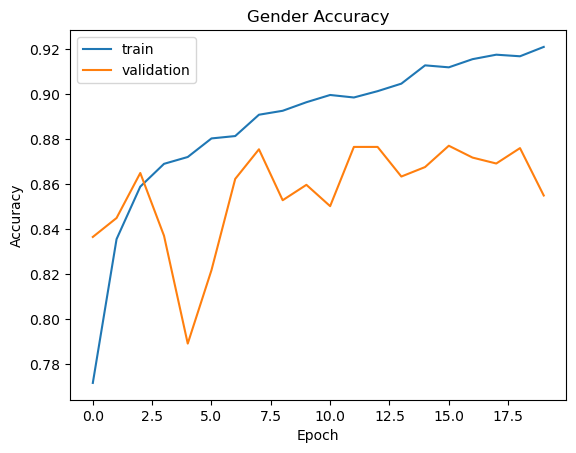

In [24]:
# Plotting gender accuracy 
plt.plot(history.history['gender_output_accuracy'])
plt.plot(history.history['val_gender_output_accuracy'])
plt.title('Gender Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Above, we can visualize the **gender prediction accuracy** for the train and validation sets across 20 epochs. Train accuracy increased dramatically after the first and second epochs. Train accuracy continued to increase as epochs increased, and the accuracy eventually reached 0.9045 at epoch=20. On the other hand, the validation accuracy fluctuated greatly across epochs. Despite this, the highest validation accuracy was 0.8935 at epoch=13. 

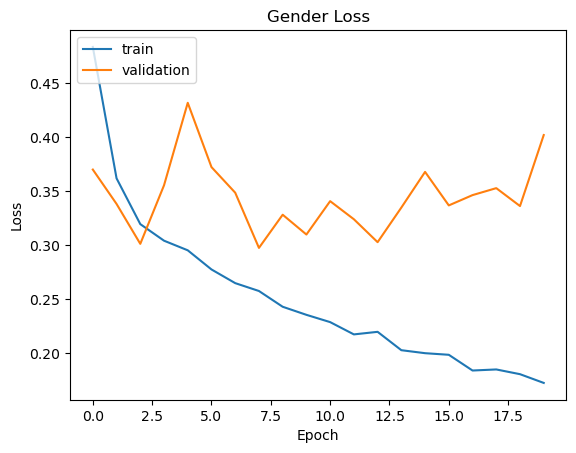

In [27]:
# Plotting gender loss 
plt.plot(history.history['gender_output_loss'])
plt.plot(history.history['val_gender_output_loss'])
plt.title('Gender Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Above, we can visualize the **gender prediction loss** for the train and validation sets across 20 epochs. For the train set, the loss continued to gradually decrease after the first epoch. However, this decrease was very minimal. The lowest loss for the train set was 0.2038 and occurred at epoch=20. In contrast to this, the validation loss fluctuated greatly across epochs. In fact, the validation loss significantly increased to 6.0297 at epoch=5. The validation loss began to decrease significantly as epochs increased, however, it still fluctuated greatly. The lowest loss for the validation set was 0.4530 and occured at epoch=1. 

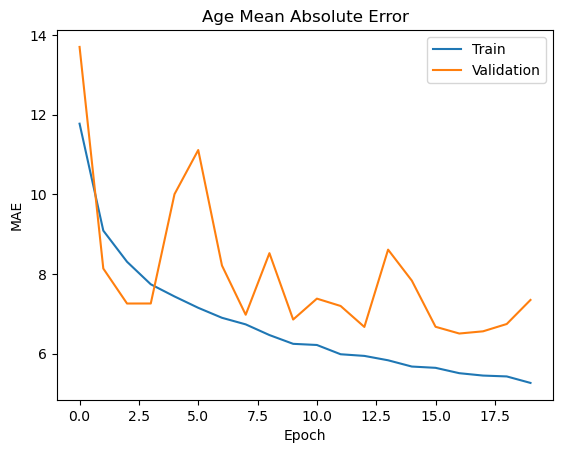

In [28]:
# Plotting Age MAE (Mean Absolute Error)
plt.plot(history.history['age_output_mae'])
plt.plot(history.history['val_age_output_mae'])
plt.title('Age Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


Overall, age accuracy was significantly worse when compared to gender accuracy. The plot above shows the **age prediction accuracy**. Surprisingly, the accuracy of both train and validation sets decreased significantly after the first epoch. Moreover, both tended to fluctuate greatly across epochs. The best accuracy for the train set was 0.0427 at epoch=1. The best accuracy for the validation set was 0.0474 at epoch=1. 

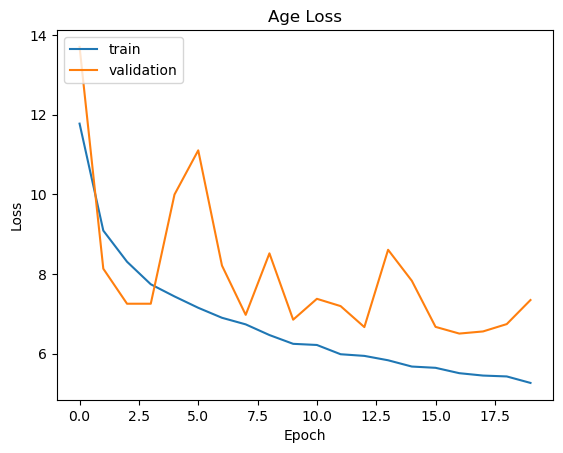

In [29]:
# Plotting age loss 
plt.plot(history.history['age_output_loss'])
plt.plot(history.history['val_age_output_loss'])
plt.title('Age Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

The plot above shows the **age prediction loss**. For the train set, the loss gradually decreased across epochs and reached 5.4053 at epoch=20. For the validation set, the loss fluctuated greatly across epochs and reached 7.8650 at epoch=16. 

Original: Gender =  Male  Age =  34.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
Prediction: Gender =  Male  Age =  29


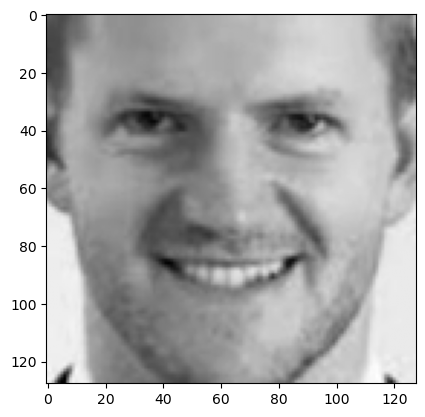

In [30]:
# Applying model predictions to a test image
index=20
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])] 
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')

In [31]:
import joblib

# Save model weights and architecture path
model.save("age_gender_model.keras")

# Save metadata or pipeline info using joblib
info = {
    "model_path": "age_gender_model.keras",
    "description": "Keras model for age & gender prediction"
}
joblib.dump(info, "model_aagp.joblib")

print("✅ Model saved as Keras file; metadata saved with joblib.")


✅ Model saved as Keras file; metadata saved with joblib.


In [32]:
from tensorflow.keras.models import load_model
import joblib
import pickle

# --- Save your model normally ---
model.save("aagp.keras")  # Full model saved

# --- Save metadata / reference for reproducibility ---
model_info = {
    "model_path": "aagp.keras",
    "description": "Keras model for age & gender prediction",
    "input_shape": model.input_shape,
    "output_names": [out.name for out in model.outputs]
}

# Save metadata using joblib
joblib.dump(model_info, "model_aagp.joblib")

# Save metadata using pickle
with open("model_aagp.pkl", "wb") as f:
    pickle.dump(model_info, f)

print("✅ Saved model as:")
print("  - aagp.keras (actual model)")
print("  - model_aagp.joblib (metadata)")
print("  - model_aagp.pkl (metadata)")


✅ Saved model as:
  - aagp.keras (actual model)
  - model_aagp.joblib (metadata)
  - model_aagp.pkl (metadata)


In the example above, we can see how our model predicts the gender and age of a test image. Fortunately, the model was able to correctly identify the gender of the image. However, the model was unable to predict the age. In fact, the age provided was completely different from the correct age. 

<a id="conclusion"></a>
# **Conclusion**

Model Performance (Gender):
- Best Gender Prediction Accuracy (Train): 0.9045
- Best Gender Prediction Accuracy (Validation): 0.8935
- Best Gender Prediction Loss (Train): 0.2038
- Best Gender Prediction Loss (Validation): 0.4530

Model Performance (Age):
- Best Age Prediction Accuracy (Train): 0.0427
- Best Age Prediction Accuracy (Validation): 0.0474
- Best Age Prediction Loss (Train): 5.4053
- Best Age Prediction Loss (Validation): 7.8650

From the statistics shown above, it is clear that the CNN model used here is extremely good at predicting gender but is also extremely bad at predicting age. The drastic fluctuations in the validation loss for both gender and age suggest that the model is likely overfitting the data. In fact, the model may have too many parameters for the relatively small amount of data used here. As I am using this project as a learning experience, I am still quite happy with the result. Future changes or implementations to this project could include:
- Reducing layers of CNN model, e.g. reducing the number of convolutional and dense layers
- Adding more regularization to the model
- Training on a smaller number of images

Thank you for taking the time to view my project! If you found this interesting, please feel free to leave a like! :)

<a id="ref"></a>
# **References**

- https://www.kaggle.com/datasets/jangedoo/utkface-new?datasetId=44109
- https://susanqq.github.io/UTKFace/
- https://www.kaggle.com/code/venugopalkadamba/face-regeneration-using-autoencoders
- https://www.kaggle.com/code/uzzivirus/age-and-gender-detection/notebook#Creating-model
- https://www.kaggle.com/code/rahuldshetty/age-and-gender-estimation-using-cnn